## 前処理見直し
- 階数をカテゴリ化したのは正しかったのか？
  - A~Gの順になっているが、その順に助かりやすかったのか不明。例えば真ん中の階層が助かりやすい可能性もある。
    - 階数と生存の分布をチェックする
      - 線形に増減するようであればカテゴリ化したままで良い
      - ばらつきが大きいならOneHotEncodingに変更する
- 客室番号の数値をそのまま使って良かったのか？
  - 階数の情報を抜いたことで、例えばA10とF10のような、本来は遠い客室を似た特徴を持っていると判定されていないか。
    - 客室番号と生存の相関をチェックする
      - 高ければ不正解の原因の可能性
    - 階数を含んだデータ変換をする
      - 例えば `階数 * 100 + 部屋番号` のようにして、階数の影響を除外しない数値にする
        （階数にかける数値は部屋番号の最大桁数以上）
- 外れ値の除外
        

In [2]:
import numpy as np
import pandas as pd

In [3]:
titanic = pd.read_csv('./titanic/train.csv')

In [24]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [37]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 外れ値除外

外れ値が発生するデータとしてはFare, Ageか。それらの外れ値を除外して予測精度向上を図る。

### Fare

array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

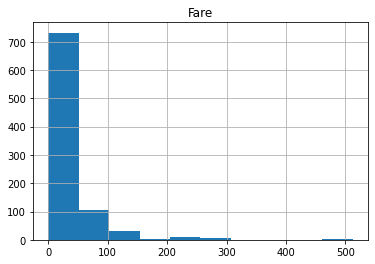

In [75]:
titanic[["Fare"]].hist()

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

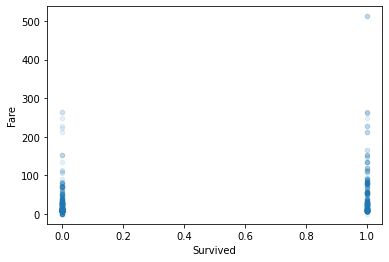

In [4]:
titanic.plot(kind="scatter", x="Survived", y="Fare", alpha=0.1)

In [39]:
len(titanic.query("Fare == 0"))

15

In [38]:
len(titanic.query("Fare > 200"))

20

array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

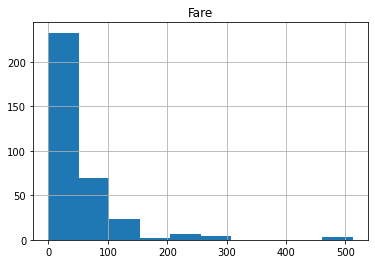

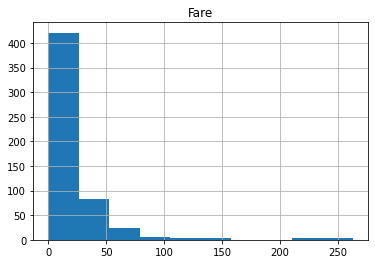

In [272]:
titanic.query("Survived == 1")[["Fare"]].hist()
titanic.query("Survived != 1")[["Fare"]].hist()

手動でこのくらいの閾値で良いか？

In [23]:
from sklearn.neighbors import LocalOutlierFactor

local_outlier_factor = LocalOutlierFactor(contamination='auto', novelty=True)
local_outlier_factor.fit(titanic[["Fare"]])
predicted = local_outlier_factor.predict(titanic[["Fare"]])
predicted[:10]

array([-1,  1, -1,  1,  1,  1,  1,  1, -1,  1])

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

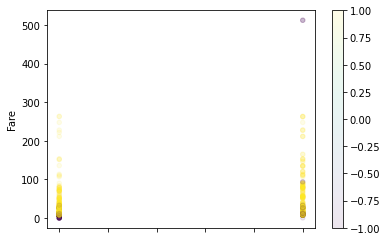

In [29]:
titanic.plot(kind="scatter", x="Survived", y="Fare", alpha=0.1, c=predicted, cmap="viridis")

### Age

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

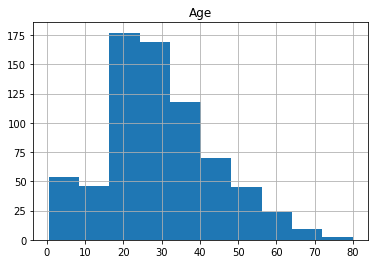

In [74]:
titanic[["Age"]].hist()

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

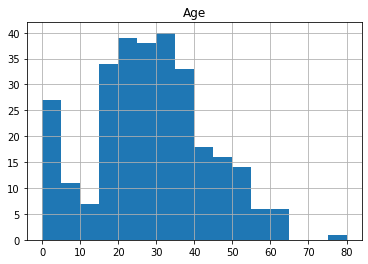

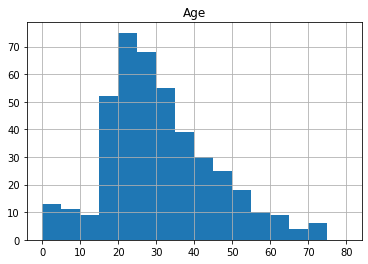

In [84]:
titanic.query("Survived == 1")[["Age"]].hist(range=(0,80), bins=16)
titanic.query("Survived != 1")[["Age"]].hist(range=(0,80), bins=16)

In [93]:
titanic.query("Age >= 60").sort_values("Age")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
587,588,1,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,13567,79.2000,B41,C
694,695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S
684,685,0,2,"Brown, Mr. Thomas William Solomon",male,60.0,1,1,29750,39.0000,NaN,S
366,367,1,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60.0,1,0,110813,75.2500,D37,C
625,626,0,1,"Sutton, Mr. Frederick",male,61.0,0,0,36963,32.3208,D50,S
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S
170,171,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,111240,33.5000,B19,S
570,571,1,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0000,B28,NaN
555,556,0,1,"Wright, Mr. George",male,62.0,0,0,113807,26.5500,NaN,S


`Age <= 80` を条件に除外で良いかな

In [61]:
titanic.query("Age <= 10")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,1,PP 9549,16.7000,G6,S
16,17,0,3,"Rice, Master. Eugene",male,2.00,4,1,382652,29.1250,NaN,Q
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.00,3,1,349909,21.0750,NaN,S
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.00,1,2,SC/Paris 2123,41.5792,NaN,C
...,...,...,...,...,...,...,...,...,...,...,...,...
827,828,1,2,"Mallet, Master. Andre",male,1.00,0,2,S.C./PARIS 2079,37.0042,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.00,4,2,347082,31.2750,NaN,S
852,853,0,3,"Boulos, Miss. Nourelain",female,9.00,1,1,2678,15.2458,NaN,C


想像していたより多い。0.83は誤入力のなのか、1歳未満なのか。一定以下の年齢であれば親に左右されるのが大きいか？

In [87]:
titanic.query("Age < 1")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


1歳未満の扱いで良さそう。

年齢軸のヒストグラムと合わせて考えると、下の方の外れ値除外は不要。むしろ「5歳以下」という特徴量を作成しても良いくらい生存率が大きい。

## 前処理フィルタ修正

In [100]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(titanic, test_size=0.2, random_state=39)

y_train = train[["Survived"]]
X_train = train.drop(y_train.columns, axis=1)

y_test = train[["Survived"]]
X_test = test.drop(y_test.columns, axis=1)

### 年齢外れ値フィルタ

In [119]:
from sklearn.base import BaseEstimator, TransformerMixin

class AgeFilter(BaseEstimator, TransformerMixin):

  def __init__(self, top=80, bottom=0):
    self.top = top
    self.bottom = bottom
    return

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    return X[(X["Age"] < self.top) & (X["Age"] > self.bottom)]

In [120]:
_filter = AgeFilter()
_filter.fit_transform(X_train)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
129,130,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S
701,702,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,E24,S
344,345,2,"Fox, Mr. Stanley Hubert",male,36.0,0,0,229236,13.0000,NaN,S
544,545,1,"Douglas, Mr. Walter Donald",male,50.0,1,0,PC 17761,106.4250,C86,C
870,871,3,"Balkic, Mr. Cerin",male,26.0,0,0,349248,7.8958,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
227,228,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
582,583,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,NaN,S
41,42,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S
105,106,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,NaN,S


### 乳幼児属性追加

In [117]:
X_train["Age"] <= 5
X_train.assign(Baby=X_train["Age"] <= 5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Baby
129,130,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S,False
793,794,1,"Hoyt, Mr. William Fisher",male,NaN,0,0,PC 17600,30.6958,NaN,C,False
701,702,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,E24,S,False
601,602,3,"Slabenoff, Mr. Petco",male,NaN,0,0,349214,7.8958,NaN,S,False
344,345,2,"Fox, Mr. Stanley Hubert",male,36.0,0,0,229236,13.0000,NaN,S,False
...,...,...,...,...,...,...,...,...,...,...,...,...
582,583,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,NaN,S,False
64,65,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,NaN,C,False
41,42,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S,False
105,106,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,NaN,S,False


In [121]:
from sklearn.base import BaseEstimator, TransformerMixin

class BabyAppender(BaseEstimator, TransformerMixin):

  def __init__(self, limit=5):
    self.limit = limit 
    return

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    return X.assign(Baby=X["Age"] <= self.limit)

In [124]:
BabyAppender().fit_transform(X_train)[:20]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Baby
129,130,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S,False
793,794,1,"Hoyt, Mr. William Fisher",male,NaN,0,0,PC 17600,30.6958,NaN,C,False
701,702,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,E24,S,False
601,602,3,"Slabenoff, Mr. Petco",male,NaN,0,0,349214,7.8958,NaN,S,False
344,345,2,"Fox, Mr. Stanley Hubert",male,36.0,0,0,229236,13.0000,NaN,S,False
544,545,1,"Douglas, Mr. Walter Donald",male,50.0,1,0,PC 17761,106.4250,C86,C,False
347,348,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,NaN,1,0,386525,16.1000,NaN,S,False
870,871,3,"Balkic, Mr. Cerin",male,26.0,0,0,349248,7.8958,NaN,S,False
220,221,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S,False
281,282,3,"Olsson, Mr. Nils Johan Goransson",male,28.0,0,0,347464,7.8542,NaN,S,False


In [140]:
X_train["Cabin"].values[:10]

array([nan, nan, 'E24', nan, nan, 'C86', nan, nan, nan, nan], dtype=object)

In [153]:
# cabinの分割
from sklearn.base import BaseEstimator, TransformerMixin

def split_cabins(cabins):
  _floors = []
  _numbers = []

  for cabin in cabins.astype(str):
    if cabin == 'nan' or not cabin:
      _floors.append(np.nan)
      _numbers.append(np.nan)
      continue
    else:
      _first_cabin = cabin.split(" ")[0]
      floor = _first_cabin[0]
      number = _first_cabin[1:]
      _floors.append(floor)
      _numbers.append(number if number else np.nan)

  return _floors, np.array(_numbers, dtype=np.float64)

class CabinConverter(BaseEstimator, TransformerMixin):

  def __init__(self, cabin_ix = 0, omit_floor_number=False):
    self.cabin_ix = cabin_ix
    self.omit_floor_number = omit_floor_number
    return

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    cabins = X["Cabin"].values
    floors, numbers = split_cabins(cabins)
    _X = X.drop("Cabin", axis=1)
    if self.omit_floor_number:
      return _X.assign(Floor=floors)
    else:
      return _X.assign(Floor=floors, CabinNumber=numbers)

In [154]:
CabinConverter().fit_transform(X_train)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Floor,CabinNumber
129,130,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,S,NaN,NaN
793,794,1,"Hoyt, Mr. William Fisher",male,NaN,0,0,PC 17600,30.6958,C,NaN,NaN
701,702,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,S,E,24.0
601,602,3,"Slabenoff, Mr. Petco",male,NaN,0,0,349214,7.8958,S,NaN,NaN
344,345,2,"Fox, Mr. Stanley Hubert",male,36.0,0,0,229236,13.0000,S,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
582,583,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,S,NaN,NaN
64,65,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,C,NaN,NaN
41,42,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,S,NaN,NaN
105,106,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,S,NaN,NaN


In [155]:
from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer

before_split_pipeline = Pipeline([
  ('age-filter', AgeFilter()),
  ('baby-appender', BabyAppender()),
  ('converter', CabinConverter()),
])

In [157]:
before_split_pipeline.fit_transform(X_train)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Baby,Floor,CabinNumber
129,130,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,S,False,NaN,NaN
701,702,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,PC 17475,26.2875,S,False,E,24.0
344,345,2,"Fox, Mr. Stanley Hubert",male,36.0,0,0,229236,13.0000,S,False,NaN,NaN
544,545,1,"Douglas, Mr. Walter Donald",male,50.0,1,0,PC 17761,106.4250,C,False,C,86.0
870,871,3,"Balkic, Mr. Cerin",male,26.0,0,0,349248,7.8958,S,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,228,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,S,False,NaN,NaN
582,583,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,S,False,NaN,NaN
41,42,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,S,False,NaN,NaN
105,106,3,"Mionoff, Mr. Stoytcho",male,28.0,0,0,349207,7.8958,S,False,NaN,NaN


In [171]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

scaler_pipeline = Pipeline([
  ('imputer', SimpleImputer()),
  ('std_scaler', StandardScaler()),
])

transformer = ColumnTransformer([ 
  ("num", SimpleImputer(strategy="median"), ["Pclass", "Fare"]),
  ("scale", scaler_pipeline, ["Age"]),
  ("onehot", OneHotEncoder(), ["Sex", "Floor"]),
])

In [174]:
filter = AgeFilter()
_train = filter.fit_transform(train)
y_train = _train[["Survived"]]
X_train = _train.drop(y_train.columns, axis=1)

y_test = train[["Survived"]]
X_test = test.drop(y_test.columns, axis=1)

In [176]:
_X_train = transformer.fit_transform(X_train)
clf = RandomForestClassifier(random_state=38)
clf.fit(_X_train, y_train)
cross_val_score(clf, _X_train, y_train, cv=3, scoring="accuracy")

ValueError: A given column is not a column of the dataframe

In [179]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.pipeline import Pipeline

dataframe_pipeline = Pipeline([
  ('baby-appender', BabyAppender()),
  ('converter', CabinConverter()),
])

scaler_pipeline = Pipeline([
  ('imputer', SimpleImputer()),
  ('std_scaler', StandardScaler()),
])

col_transformer = ColumnTransformer([ 
  ("num", SimpleImputer(strategy="median"), ["Pclass", "Fare"]),
  ("scale", scaler_pipeline, ["Age"]),
  ("onehot", OneHotEncoder(), ["Sex", "Floor"]),
  ("passthrough", "passthrough", ["Baby"])
])

whole_pipeline = Pipeline([
  ('dataframe', dataframe_pipeline),
  ('std_scaler', col_transformer),
])

In [187]:
# filter = AgeFilter()
# _train = filter.fit_transform(train)
y_train = _train["Survived"]
X_train = _train.drop("Survived", axis=1)

_X_train = whole_pipeline.fit_transform(X_train)
clf = RandomForestClassifier(random_state=38)
clf.fit(_X_train, y_train)
cross_val_score(clf, _X_train, y_train, cv=3, scoring="accuracy")

array([0.82198953, 0.77368421, 0.82631579])

In [193]:
y_test = test["Survived"]
X_test = test.drop("Survived", axis=1)

In [196]:
_X_test = whole_pipeline.fit_transform(X_test)
# _X_test[0]
clf.predict(_X_test)

ValueError: X has 15 features, but DecisionTreeClassifier is expecting 14 features as input.

In [216]:
_X_test = dataframe_pipeline.fit_transform(X_test)
_enc = OneHotEncoder()
_res = _enc.fit_transform(_X_test[["Floor"]])
_res

<179x9 sparse matrix of type '<class 'numpy.float64'>'
	with 179 stored elements in Compressed Sparse Row format>

In [213]:
_enc.categories_

[array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan], dtype=object)]

In [220]:
_X_train = dataframe_pipeline.fit_transform(X_train)
_enc = OneHotEncoder()
_res = _enc.fit_transform(_X_train[["Floor"]])
_res

<571x8 sparse matrix of type '<class 'numpy.float64'>'
	with 571 stored elements in Compressed Sparse Row format>

In [221]:
_enc.categories_

[array(['A', 'B', 'C', 'D', 'E', 'F', 'G', nan], dtype=object)]

In [226]:
cabins = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', np.nan]

In [232]:
_X_train = dataframe_pipeline.fit_transform(X_train)
_enc = OneHotEncoder(categories=[cabins])
_res = _enc.fit_transform(_X_train[["Floor"]])
_res.toarray()[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [228]:
_enc

OneHotEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan]])

In [245]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.pipeline import Pipeline

dataframe_pipeline = Pipeline([
  ('baby-appender', BabyAppender()),
  ('converter', CabinConverter()),
])

scaler_pipeline = Pipeline([
  ('imputer', SimpleImputer()),
  ('std_scaler', StandardScaler()),
])

col_transformer = ColumnTransformer([ 
  ("num", SimpleImputer(strategy="median"), ["Pclass", "Fare"]),
  ("scale", scaler_pipeline, ["Age"]),
  ("sex", OneHotEncoder(), ["Sex"]),
  ("floor", OneHotEncoder(categories=[cabins]), ["Floor"]),
  ("passthrough", "passthrough", ["Baby"])
])

whole_pipeline = Pipeline([
  ('dataframe', dataframe_pipeline),
  ('std_scaler', col_transformer),
])

In [246]:
# filter = AgeFilter()
# _train = filter.fit_transform(train)
y_train = _train["Survived"]
X_train = _train.drop("Survived", axis=1)

_X_train = whole_pipeline.fit_transform(X_train)
clf = RandomForestClassifier(random_state=38)
clf.fit(_X_train, y_train)
cross_val_score(clf, _X_train, y_train, cv=3, scoring="accuracy")

array([0.81151832, 0.76315789, 0.82631579])

In [247]:
pd.DataFrame(_X_train[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3.0,6.9750,1.082948,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,26.2875,0.381312,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,13.0000,0.451475,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,106.4250,1.433766,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,7.8958,-0.250161,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [248]:
pd.DataFrame(_X_test[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,512.3292,0.415890,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,51.8625,1.713987,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,26.0000,0.451948,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,8.4042,0.848589,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,38.5000,1.209171,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [251]:
_X_test = whole_pipeline.fit_transform(X_test)
predict = clf.predict(_X_test)
predict

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [253]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predict)

array([[101,  22],
       [ 21,  35]])

In [255]:
cross_val_score(clf, _X_test, y_test, cv=3, scoring="accuracy")

array([0.81666667, 0.76666667, 0.77966102])

In [256]:
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

param_grid = [
  { 
    # "criterion": ["gini", "entropy"],
    "class_weight": ["balanced"],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2,4,8,16], # 1 is not a valid parameter
    "n_estimators": [10, 100, 200],
  }
]

_clf = RandomForestClassifier(random_state=38)
_grid_search = GridSearchCV(_clf, param_grid, cv=5, scoring="accuracy", return_train_score=True)
_grid_search.fit(_X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=38),
             param_grid=[{'class_weight': ['balanced'],
                          'max_features': ['sqrt', 'log2'],
                          'min_samples_split': [2, 4, 8, 16],
                          'n_estimators': [10, 100, 200]}],
             return_train_score=True, scoring='accuracy')

In [258]:
_grid_search.best_score_

0.8266666666666668

In [260]:
_grid_search.best_params_

{'class_weight': 'balanced',
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 100}

In [263]:
param_grid = [
  { 
    "criterion": ["gini", "entropy"],
    "class_weight": ["balanced"],
    "max_features": ["sqrt"],
    "min_samples_split": [3,4,5,6],
    "n_estimators": [50, 100, 150],
  }
]

_clf = RandomForestClassifier(random_state=38)
_grid_search = GridSearchCV(_clf, param_grid, cv=5, scoring="accuracy", return_train_score=True)
_grid_search.fit(_X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=38),
             param_grid=[{'class_weight': ['balanced'],
                          'criterion': ['gini', 'entropy'],
                          'max_features': ['sqrt'],
                          'min_samples_split': [3, 4, 5, 6],
                          'n_estimators': [50, 100, 150]}],
             return_train_score=True, scoring='accuracy')

In [264]:
_grid_search.best_score_, _grid_search.best_params_

(0.8266666666666668,
 {'class_weight': 'balanced',
  'criterion': 'gini',
  'max_features': 'sqrt',
  'min_samples_split': 4,
  'n_estimators': 100})

In [265]:
cross_val_score(_grid_search.best_estimator_, _X_test, y_test, cv=3, scoring="accuracy")

array([0.8       , 0.76666667, 0.77966102])

In [266]:
confusion_matrix(y_test, _grid_search.best_estimator_.predict(_X_test))

array([[99, 24],
       [15, 41]])

In [267]:
titanic_test = pd.read_csv('./titanic/test.csv')

In [269]:
_titanic_test = whole_pipeline.fit_transform(titanic_test)
predict = _grid_search.best_estimator_.predict(_titanic_test)
predict

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [271]:
id = np.array(titanic_test["PassengerId"]).astype(int)
df = pd.DataFrame(predict, id, columns = ["Survived"])
df.to_csv("./titanic/predict-3.csv", index_label = ["PassengerId"])

料金の外れ値除外を忘れてた。。

In [273]:
from sklearn.base import BaseEstimator, TransformerMixin

class FareFilter(BaseEstimator, TransformerMixin):

  def __init__(self, top=200, bottom=0):
    self.top = top
    self.bottom = bottom
    return

  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    return X[(X["Fare"] < self.top) & (X["Fare"] > self.bottom)]

In [274]:
filter = Pipeline([
  ("age", AgeFilter()),
  ("fare", FareFilter()),
])
_train = filter.fit_transform(train)

y_train = _train["Survived"]
X_train = _train.drop("Survived", axis=1)

_X_train = whole_pipeline.fit_transform(X_train)
clf = RandomForestClassifier(random_state=38)
clf.fit(_X_train, y_train)
cross_val_score(clf, _X_train, y_train, cv=3, scoring="accuracy")

array([0.81081081, 0.77297297, 0.83783784])

In [275]:
param_grid = [
  { 
    "criterion": ["gini", "entropy"],
    "class_weight": ["balanced"],
    "max_features": ["sqrt"],
    "min_samples_split": [3,4,5,6],
    "n_estimators": [50, 100, 150],
  }
]

_clf = RandomForestClassifier(random_state=38)
_grid_search = GridSearchCV(_clf, param_grid, cv=5, scoring="accuracy", return_train_score=True)
_grid_search.fit(_X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=38),
             param_grid=[{'class_weight': ['balanced'],
                          'criterion': ['gini', 'entropy'],
                          'max_features': ['sqrt'],
                          'min_samples_split': [3, 4, 5, 6],
                          'n_estimators': [50, 100, 150]}],
             return_train_score=True, scoring='accuracy')

In [277]:
_grid_search.best_score_, _grid_search.best_params_

(0.818018018018018,
 {'class_weight': 'balanced',
  'criterion': 'entropy',
  'max_features': 'sqrt',
  'min_samples_split': 5,
  'n_estimators': 100})

In [278]:
cross_val_score(_grid_search.best_estimator_, _X_train, y_train, cv=3, scoring="accuracy")

array([0.78378378, 0.75675676, 0.85405405])

In [279]:
cross_val_score(_grid_search.best_estimator_, _X_test, y_test, cv=3, scoring="accuracy")

array([0.8       , 0.75      , 0.74576271])

In [280]:
_titanic_test = whole_pipeline.fit_transform(titanic_test)
predict = _grid_search.best_estimator_.predict(_titanic_test)

id = np.array(titanic_test["PassengerId"]).astype(int)
df = pd.DataFrame(predict, id, columns = ["Survived"])
df.to_csv("./titanic/predict-3-2.csv", index_label = ["PassengerId"])